In [45]:
import os   
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn import metrics



In [46]:
db= pd.read_csv('car_sales.csv')
ds = db.copy()
ds.columns = ds.columns.str.replace(' ', '_') 
ds.head()

,Manufacturer,Model,Engine_size,Fuel_type,Year_of_manufacture,Mileage,Price
0,Ford,Fiesta,1.0,Petrol,2002,127300,3074
1,Porsche,718 Cayman,4.0,Petrol,2016,57850,49704
2,Ford,Mondeo,1.6,Diesel,2014,39190,24072
3,Toyota,RAV4,1.8,Hybrid,1988,210814,1705
4,VW,Polo,1.0,Petrol,2006,127869,4101


In [47]:
ds.shape
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Manufacturer         50000 non-null  object 
 1   Model                50000 non-null  object 
 2   Engine_size          50000 non-null  float64
 3   Fuel_type            50000 non-null  object 
 4   Year_of_manufacture  50000 non-null  int64  
 5   Mileage              50000 non-null  int64  
 6   Price                50000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 2.7+ MB


In [48]:
print(ds.describe()) 
print(ds.describe(include='object')) 
print(ds.duplicated().sum())  
print(ds['Manufacturer'].value_counts())
print(ds['Model'].value_counts())

        Engine_size  Year_of_manufacture        Mileage          Price
count  50000.000000         50000.000000   50000.000000   50000.000000
mean       1.773058          2004.209440  112497.320700   13828.903160
std        0.734108             9.645965   71632.515602   16416.681336
min        1.000000          1984.000000     630.000000      76.000000
25%        1.400000          1996.000000   54352.250000    3060.750000
50%        1.600000          2004.000000  100987.500000    7971.500000
75%        2.000000          2012.000000  158601.000000   19026.500000
max        5.000000          2022.000000  453537.000000  168081.000000
       Manufacturer   Model Fuel_type
count         50000   50000     50000
unique            5      15         3
top            Ford  Mondeo    Petrol
freq          14959    5058     25488
12
Manufacturer
Ford       14959
VW         14913
Toyota     12554
BMW         4965
Porsche     2609
Name: count, dtype: int64
Model
Mondeo        5058
Golf          5050


<Figure size 1200x800 with 0 Axes>

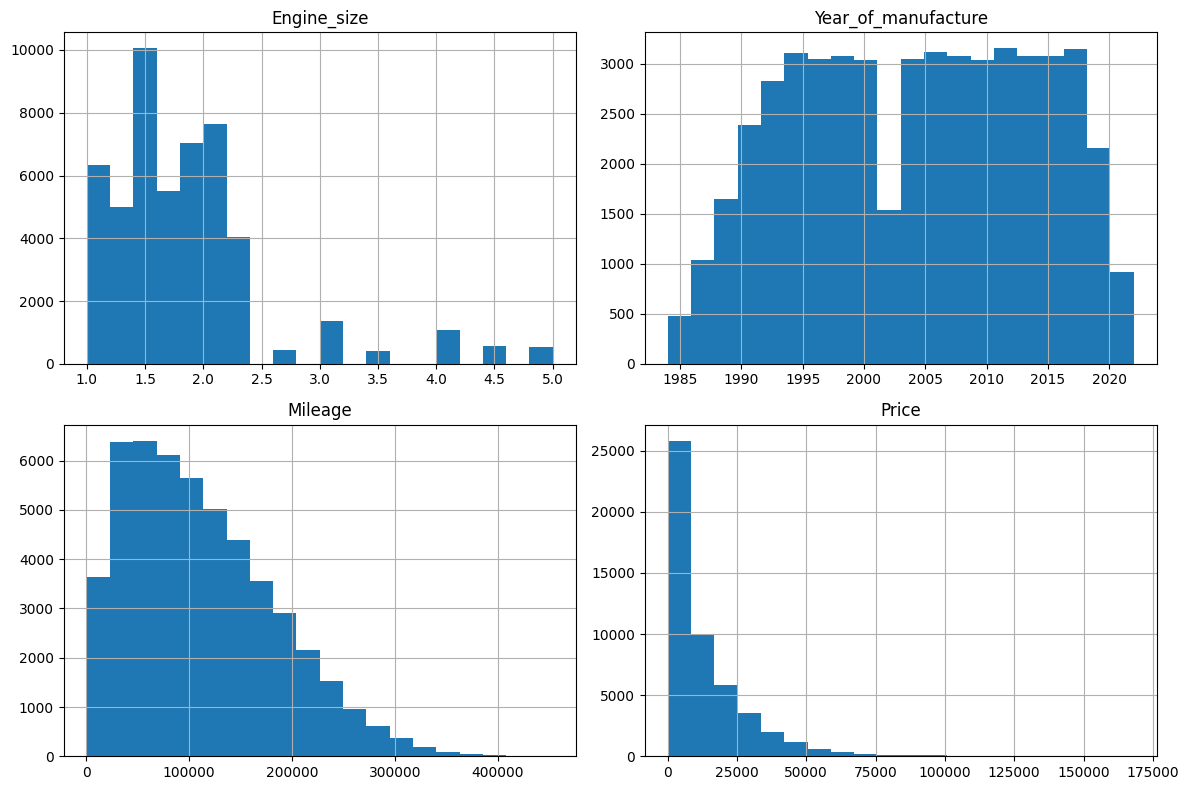

In [49]:
#histogram and save it as a PNG file

plt.figure(figsize=(12, 8))
ds.hist(bins=20, figsize=(12, 8))
plt.tight_layout()
histogram_path = os.path.join("visualisation of data" , "data_distributions.png")
plt.savefig(histogram_path, dpi=300)
plt.show()
plt.close()


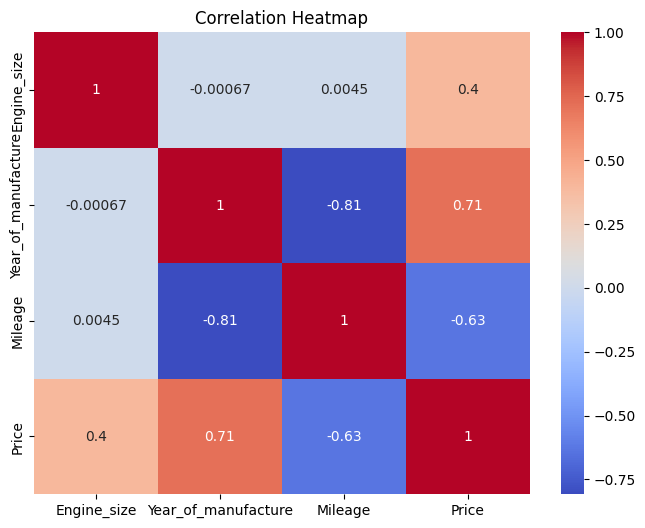

In [50]:
#heatmap and save it as a PNG file
numerics = ds.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(8, 6))
sns.heatmap(numerics.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
heatmap_path = os.path.join("visualisation of data" , "correlation_heatmap.png")
plt.savefig(heatmap_path, dpi=300)
plt.show()
plt.close()

In [51]:
 #data distribution and correlation analysis
 
print("Skewness (higher = more right-skewed):")
print(ds.select_dtypes(include=['float64', 'int64']).skew().sort_values(ascending=False))

print("\nTop corrs with Price:")
numerics = ds.select_dtypes(include=['float64', 'int64'])
print(numerics.corr()['Price'].sort_values(ascending=False))

print("\nCategorical cardinality:")
cats = ds.select_dtypes(include='object').columns
for col in cats:
    print(f"{col}: {ds[col].nunique()} uniques")

Skewness (higher = more right-skewed):
Price                  2.850159
Engine_size            2.077592
Mileage                0.725141
Year_of_manufacture   -0.062166
dtype: float64

Top corrs with Price:
Price                  1.000000
Year_of_manufacture    0.714209
Engine_size            0.398371
Mileage               -0.632692
Name: Price, dtype: float64

Categorical cardinality:
Manufacturer: 5 uniques
Model: 15 uniques
Fuel_type: 3 uniques


In [52]:
#prepare target and features in log scale

if 'Log_Price' not in ds.columns:
	ds['Log_Price'] = np.log(ds['Price'] + 1)
target_col = 'Log_Price'
y = ds[target_col]
X = ds.drop(['Price', 'Log_Price'], axis=1, errors='ignore')  
print("Features:", X.columns.tolist())
print("Shape:", X.shape)

Features: ['Manufacturer', 'Model', 'Engine_size', 'Fuel_type', 'Year_of_manufacture', 'Mileage']
Shape: (50000, 6)


In [53]:
# detect_num_cat_cols
cat_cols = ['Manufacturer', 'Model', 'Fuel_type']
num_cols = []
for col in ['Engine_size', 'Age', 'Mileage', 'Log_Mileage']:
    if col in X.columns:
        num_cols.append(col)
if 'Mileage_Bin' in X.columns:
    cat_cols.append('Mileage_Bin')

print(f"Num cols used: {num_cols}")
print(f"Cat cols used: {cat_cols}")

Num cols used: ['Engine_size', 'Mileage']
Cat cols used: ['Manufacturer', 'Model', 'Fuel_type']


In [54]:
# train/test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train/Test shapes:", X_train.shape, X_test.shape)

Train/Test shapes: (40000, 6) (10000, 6)


In [55]:
# build_preprocessor

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cat_cols)
    ],
    remainder='passthrough'  
)

In [56]:
# build and train model pipeline

pipeline = Pipeline([
    ('prep', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])
pipeline.fit(X_train, y_train)
print("Model trained")

Model trained


In [42]:

#Performance Metrics Summary
y_pred_log = pipeline.predict(X_test)
y_pred = np.exp(y_pred_log) - 1
y_test_orig = np.exp(y_test) - 1
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
mae = mean_absolute_error(y_test_orig, y_pred)
r2 = r2_score(y_test_orig, y_pred)
print(f"\nResults:")
print(f"MAE: ${mae:,.0f}")
print(f"RMSE: ${rmse:,.0f}")
print(f"R²: {r2:.3f}")


Results:
MAE: $305
RMSE: $694
R²: 0.998


In [57]:
#Feature Importance Analysis

importances = pipeline.named_steps['rf'].feature_importances_
cat_names = pipeline.named_steps['prep'].named_transformers_['cat'].get_feature_names_out(cat_cols)
feature_names = num_cols + list(cat_names)
top10 = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 Importances:")
for name, imp in top10:
    print(f"{name:<25}: {imp:.3f}")


Top 10 Importances:
Mileage                  : 0.166
Engine_size              : 0.091
Fuel_type_Petrol         : 0.008
Model_Polo               : 0.003
Model_911                : 0.003
Manufacturer_Toyota      : 0.002
Model_Golf               : 0.001
Model_Fiesta             : 0.001
Model_Focus              : 0.001
Model_Prius              : 0.001


In [58]:
# Sample Predictions First 10 Test Rows

test_sample = pd.DataFrame({
    'Actual_Price': y_test_orig.iloc[:10].values,
    'Predicted_Price': y_pred[:10],
    'Difference (Error)': y_test_orig.iloc[:10].values - y_pred[:10]
})
test_sample['Error_%'] = (test_sample['Difference (Error)'] / test_sample['Actual_Price']) * 100
print("\n Sample Predictions (First 10 Test Rows):")
print(test_sample.round(0))


 Sample Predictions (First 10 Test Rows):
   Actual_Price  Predicted_Price  Difference (Error)  Error_%
0       68597.0          67474.0              1123.0      2.0
1       35276.0          35573.0              -297.0     -1.0
2       17370.0          17613.0              -243.0     -1.0
3        3213.0           3126.0                87.0      3.0
4        4832.0           4840.0                -8.0     -0.0
5       12110.0          12098.0                12.0      0.0
6        1948.0           1844.0               104.0      5.0
7       11887.0          11587.0               300.0      3.0
8        6083.0           6277.0              -194.0     -3.0
9        5081.0           5035.0                46.0      1.0
